# Part 1: S&P 500 Stock Price Forecast
> **Motivation:** Beginning in March 2020 during the COVID pandemic, the stock market was turbulent. I want to know if it would have been possible to predict stock prices using RNNs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import datetime
import yfinance as yf
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import EarlyStopping

## I) EDA

In [2]:
def candlestick(df, title, begin_year='1975'):
    # Plot candlestick chart
    temp = df[df.index > begin_year]
    fig = go.Figure(data=[go.Candlestick(x=temp.reset_index()['Date'],
                open=temp['Open'],
                high=temp['High'],
                low=temp['Low'],
                close=temp['Adj Close'])])
    
    fig.update_layout(title=title,
                      yaxis_title="USD")

    fig.show()

### Analyze the Stock Market
The S&P 500 Index is largely considered an essential benchmark of the stock market. I will analyze it to gain insight about the market

In [3]:
SP500 = yf.download('^GSPC')

[*********************100%***********************]  1 of 1 completed


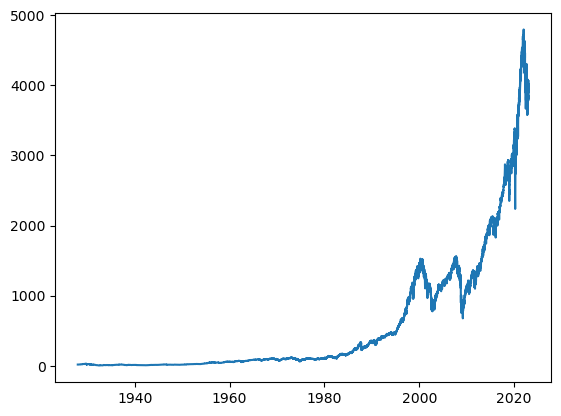

In [44]:
# Generic plot of S&P 500 stock price 
# candlestick(SP500,'S&P 500: Market Summary')
plt.plot(SP500['Adj Close'])

In [5]:
def annual_percent_change(df):
    # Calculates percent annual return
    # Input: df[Date, Open, High, Low, Close, Adj Close]
    # Output: df[Year, Open, High, Low, Close, % Change]] 
    
    years = np.unique(np.array(SP500.index.year))[0:-1]
    percent_change = []
    year_open, year_close = [], [] 
    year_low, year_high = [], []

    for i in years:
        temp = df[(df.index >= str(i)) & (df.index < str(i+1))]['Adj Close']
        percent_change.append(round((temp[-1] / temp[0] - 1) * 100, 2))
        year_open.append(temp[0])
        year_close.append(temp[-1])
        year_low.append(min(temp))
        year_high.append(max(temp))
    
    result = pd.DataFrame({'Date':years, 
                         'Open': year_open,
                         'Close': year_close,
                         'Low': year_low,
                         'High': year_high,
                         '% Change': percent_change}).set_index('Date')
    return result 

SP500_YoY = annual_percent_change(SP500)

In [6]:
average_annual_return = np.mean(SP500_YoY[SP500_YoY.index >= 1950]['% Change'])

SP500_2019 = SP500_YoY[SP500_YoY.index == 2019]['% Change']
SP500_2020 = SP500_YoY[SP500_YoY.index == 2020]['% Change']
SP500_2021 = SP500_YoY[SP500_YoY.index == 2021]['% Change']

SP500_2019, SP500_2020, SP500_2021, average_annual_return

(Date
 2019    28.71
 Name: % Change, dtype: float64,
 Date
 2020    15.29
 Name: % Change, dtype: float64,
 Date
 2021    28.79
 Name: % Change, dtype: float64,
 8.894246575342464)

The S&P500 index has delivered an average annual growth rate of 8.7% since 1950. However, this rule of thumb did not apply during the pandemic.
* In 2019, S&P 500 grew  **29%**
* In 2020, S&P 500 grew **15%**
* In 2021, S&P 500 grew **29%** 

In [7]:
# Plot % Annual Growth
temp = SP500_YoY[SP500_YoY.index > 1950].reset_index() # Only include recent data, (1950 and beyond)
fig = px.bar(temp, x="Date", y="% Change", title='S&P 500: Annual Growth')
fig.update_layout(xaxis_title='Year', yaxis_title='Percent Annual Growth (%)')

In [8]:
# Calculate percentile 
stats.percentileofscore(SP500_YoY['% Change'], SP500_2019), stats.percentileofscore(SP500_YoY['% Change'], SP500_2020), stats.percentileofscore(SP500_YoY['% Change'], SP500_2021)

(array([90.625]), array([64.58333333]), array([91.66666667]))

The plot above shows the percent annual growth in price between 1950 and 2022. We occasionally see long positive streches, often followed by a big negative year. The 2019-2022 market is certainly bullish, with a growth rate in the **90th, 60th, and 90th percentile** which is reminiscent of the **dot-com bubble in the late 90s.**


## II) Modeling and Prediction
* **Objective**: Predict stock prices one day in advance. 

* Because future stock prices are very reliant on past prices, I will use the LSTM model which are a special kind of RNN, capable of learning long-term dependencies

### Preprocessing

In [9]:
def split(df, split_ratio):
    # Takes in a df and splits it into train and test df
    
    numrows_train = round(split_ratio * df.shape[0])
    train_df = df[0:numrows_train]
    test_df = df[numrows_train:]
    return train_df, test_df

In [10]:
df = SP500
split_ratio = 0.75

train_df, test_df = split(df, split_ratio)

In [11]:
train_df

Open         High          Low        Close    Adj Close  \
Date                                                                          
1927-12-30    17.660000    17.660000    17.660000    17.660000    17.660000   
1928-01-03    17.760000    17.760000    17.760000    17.760000    17.760000   
1928-01-04    17.719999    17.719999    17.719999    17.719999    17.719999   
1928-01-05    17.549999    17.549999    17.549999    17.549999    17.549999   
1928-01-06    17.660000    17.660000    17.660000    17.660000    17.660000   
...                 ...          ...          ...          ...          ...   
1999-04-30  1342.829956  1351.829956  1314.579956  1335.180054  1335.180054   
1999-05-03  1335.180054  1354.630005  1329.010010  1354.630005  1354.630005   
1999-05-04  1354.630005  1354.640015  1330.640015  1332.000000  1332.000000   
1999-05-05  1332.000000  1347.319946  1317.439941  1347.310059  1347.310059   
1999-05-06  1347.310059  1348.359985  1322.560059  1332.050049  1332.050049   

               Volume  
Date                   
1927-12-30          0  
1928-01-03          0  
1928-01-04          0  
1928-01-05          0  
1928-01-06          0  
...               ...  
1999-04-30  936500000  
1999-05-03  811400000  
1999-05-04  933100000  
1999-05-05  913500000  
1999-05-06  875400000  

[17912 rows x 6 columns]

In [12]:
def offset(array, n_features):
    # array: an array of normalized training or test data
    # n_features: use past n days of data as the feature to predict price
    # lookahead: how many days in the future you want to predict
        # Output: x_train and y_train
    x, y = [], []
    
    for i in range(n_features, len(array)-1):
        x.append(array[i-n_features:i])
        y.append(array[i, 0])

    return np.array(x), np.array(y)

In [13]:
scaler = MinMaxScaler(feature_range = (0,1))
n_features = 30 # Use the last 60 days as a feature

# Normalize training and test data
train_scaled = scaler.fit_transform(train_df['Adj Close'].values.reshape(-1,1))
test_scaled = scaler.fit_transform(test_df['Adj Close'].values.reshape(-1,1))

x_train, y_train = offset(train_scaled, n_features)
x_test, y_test = offset(test_scaled, n_features)

### Build model
Future stock prices are very reliant on past prices, so I will use the LSTM model that can <...>

In [14]:
def build_model():
    K.clear_session()
    model = Sequential()

    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))
    
    return model

In [15]:
model = build_model()
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

### Train model

In [16]:
model = build_model()
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x_train, y_train, epochs=6, 
          batch_size = 32)

Epoch 1/6
559/559 [==============================] - 10s 12ms/step - loss: 8.6692e-04
Epoch 2/6
559/559 [==============================] - 7s 12ms/step - loss: 3.6682e-04
Epoch 3/6
559/559 [==============================] - 6s 12ms/step - loss: 3.1070e-04
Epoch 4/6
559/559 [==============================] - 7s 12ms/step - loss: 3.1733e-04
Epoch 5/6
559/559 [==============================] - 7s 12ms/step - loss: 3.2779e-04
Epoch 6/6
559/559 [==============================] - 7s 12ms/step - loss: 2.6239e-04


In [17]:
## Runtime Optimization, the model did not improve much past 6 epochs
# epoch, loss = [], []

# for i in range(3, 10): # Optimal num epoch
#     model = build_model()
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

#     model.fit(x_train, y_train, epochs=i, 
#   batch_size = 32)
    
#     epoch.append(i)
#     loss.append(model.evaluate(x_test, y_test))

### Predict

In [18]:
test_pred = model.predict(x_test)
test_pred = scaler.inverse_transform(test_pred)

186/186 [==============================] - 1s 4ms/step


In [19]:
summary_df = test_df[n_features-6:-7].reset_index()
summary_df['Forecasted'] = test_pred

### Analysis

In [20]:
fig = px.line(summary_df, x="Date", y=["Forecasted", 'Adj Close'], title='S&P 500: Summary and 1 Day Forecast')
fig.show()

The plot tells us that the forecasted price (blue) and true price (red) is overlapped. There are small deviations on a day-to-day basis once you zoom in, but the **model is proficient at predicting general market trends.**

In [21]:
# Residual Plot
summary_df['Residual'] = summary_df['Forecasted'] - summary_df['Adj Close']
fig = px.scatter(summary_df, 
           x='Date', y='Residual', title = 'S&P500: Residual Plot')
fig.add_hline(y=0)
fig.show()

In [22]:
# RMSE
summary_df['Squared Loss'] = (summary_df['Forecasted'] - summary_df['Adj Close'])**2
RMSE_pre = np.sqrt(summary_df['Squared Loss'][summary_df['Date']<'2018'].mean())
RMSE_post = np.sqrt(summary_df['Squared Loss'][summary_df['Date']>='2018'].mean())
RMSE_pre, RMSE_post

(16.660773935217495, 59.39905883128964)

In [23]:
# Plot Square Loss
px.scatter(summary_df, x='Date', y='Squared Loss', title = 'S&P500: Squared Loss')

In [24]:
# Ten Losses
summary_df.sort_values('Squared Loss', ascending=False)[0:10]

Date         Open         High          Low        Close  \
5228 2020-03-23  2290.709961  2300.729980  2191.860107  2237.399902   
5221 2020-03-12  2630.860107  2660.949951  2478.860107  2480.639893   
5223 2020-03-16  2508.590088  2562.979980  2380.939941  2386.129883   
5212 2020-02-28  2916.899902  2959.719971  2855.840088  2954.219971   
5792 2022-06-16  3728.179932  3728.179932  3639.770020  3666.770020   
5211 2020-02-27  3062.540039  3097.070068  2977.389893  2978.760010   
5793 2022-06-17  3665.899902  3707.709961  3636.870117  3674.840088   
5789 2022-06-13  3838.149902  3838.149902  3734.300049  3749.629883   
5227 2020-03-20  2431.939941  2453.010010  2295.560059  2304.919922   
5865 2022-09-30  3633.479980  3671.439941  3584.129883  3585.620117   

        Adj Close      Volume   Forecasted    Residual  Squared Loss  
5228  2237.399902  7411380000  2493.641602  256.241699  65659.808419  
5221  2480.639893  8850810000  2710.624756  229.984863  52893.037338  
5223  2386.129883  7805450000  2592.355225  206.225342  42528.891599  
5212  2954.219971  8569570000  3149.545410  195.325439  38152.027298  
5792  3666.770020  5644930000  3861.600830  194.830811  37959.044738  
5211  2978.760010  7064710000  3172.500977  193.740967  37535.562215  
5793  3674.840088  8520740000  3859.261230  184.421143  34011.157830  
5789  3749.629883  5636890000  3930.963135  181.333252  32881.748264  
5227  2304.919922  9053950000  2485.173340  180.253418  32491.294689  
5865  3585.620117  5645360000  3763.248779  177.628662  31551.941603

**Thoughts**
* The above scatterplot plots the **residual** and **squared loss** of our model respectably. Notice that the model has high loss everytime there is a economic turmoil (like in the late 90s and 2009s). However, the model unequivocally had the **highest loss during lockdown**. Although the model was able to predict trends even during the lockdown, it appears like the model **failed to predict the volatility of the market especially as the beginning of the pandemic.**
* From the table, we can see that the **ten highest model loss occured between February and March of 2020.**

**Other notes**
* When we used an 80:20 train-test split, the results were slightly better than 65:35. It might be because the training data learned from the dot-com bubble and was better equipped to predict the pandemic market.
* In general, the residual plots tended to overvalue. However, the spread appears random, which means the error results from noise and not systematic error.

# Part 2) ~~Tech Stocks:~~ _*Debug_

I want to see how the model would perform for the tech sector specifically, seeing how growth in the tech sector was even more pronounced during the pandemic. NASDAQ 100 Technology Sector (NDXT) is an index composed of tech companies like Alphabet, Apple, and Meta (Facebook). 

In [25]:
# df = yf.download('^NDXT')

In [26]:
# split_ratio = 0.75
# train_df, test_df = split(df, split_ratio)
# scaler = MinMaxScaler(feature_range = (0,1))

In [27]:
# n_features = 60

# # Normalize training and test data
# train_scaled = scaler.fit_transform(train_df['Adj Close'].values.reshape(-1,1))
# test_scaled = scaler.fit_transform(test_df['Adj Close'].values.reshape(-1,1))

# x_train, y_train = offset(train_scaled, n_features)
# x_test, y_test = offset(test_scaled, n_features)

In [28]:
# model = build_model()
# model.compile(loss='mean_squared_error', optimizer='adam')

# model.fit(x_train, y_train, epochs=6, 
#           batch_size = 32)

In [29]:
# test_pred = model.predict(x_test)
# test_pred = scaler.inverse_transform(test_pred)

In [30]:
# summary_df = test_df[n_features:-1].reset_index()
# summary_df['Forecasted'] = test_pred

In [31]:
# fig = px.line(summary_df, x="Date", y=["Forecasted", 'Adj Close'], title='NDXT: Summary and Forecast')
# fig.show()

In [32]:
# # RMSE
# summary_df['Squared Loss'] = (summary_df['Forecasted'] - summary_df['Adj Close'])**2
# RMSE = np.sqrt(summary_df['Squared Loss'].mean())
# RMSE

In [33]:
# # Plot Error
# summary_df['Residual'] = summary_df['Forecasted'] - summary_df['Adj Close']
# fig = px.scatter(summary_df[summary_df['Date'] > '2005'], 
#            x='Date', y='Residual', title = 'S&P500: Residual Scatterplot')
# fig.add_hline(y=0)
# fig.show()

# Part 3) Apple (AAPL)
One of the most robust stocks in the tech industry, AAPL stocks tripled in value during the pandemic.

In [34]:
df = yf.download('AAPL')

[*********************100%***********************]  1 of 1 completed


In [35]:
split_ratio = 0.65
train_df, test_df = split(df, split_ratio)
scaler = MinMaxScaler(feature_range = (0,1))

In [36]:
n_features = 60

# Normalize training and test data
train_scaled = scaler.fit_transform(train_df['Adj Close'].values.reshape(-1,1))
test_scaled = scaler.fit_transform(test_df['Adj Close'].values.reshape(-1,1))

x_train, y_train = offset(train_scaled, n_features)
x_test, y_test = offset(test_scaled, n_features)

In [37]:
model = build_model()
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(x_train, y_train, epochs=6, 
          batch_size = 32)

Epoch 1/6
214/214 [==============================] - 8s 24ms/step - loss: 0.0013
Epoch 2/6
214/214 [==============================] - 5s 23ms/step - loss: 5.4115e-04
Epoch 3/6
214/214 [==============================] - 5s 23ms/step - loss: 6.1965e-04
Epoch 4/6
214/214 [==============================] - 5s 23ms/step - loss: 5.6102e-04
Epoch 5/6
214/214 [==============================] - 5s 23ms/step - loss: 5.7275e-04
Epoch 6/6
214/214 [==============================] - 5s 23ms/step - loss: 4.0220e-04


In [38]:
test_pred = model.predict(x_test)
test_pred = scaler.inverse_transform(test_pred)

115/115 [==============================] - 1s 8ms/step


In [39]:
summary_df = test_df[n_features-6:-7].reset_index()
summary_df['Forecasted'] = test_pred

In [40]:
fig = px.line(summary_df, x="Date", y=["Forecasted", 'Adj Close'], title='AAPL: Summary and Forecast')
fig.show()

In [41]:
# RMSE
summary_df['Residual'] = summary_df['Forecasted'] - summary_df['Adj Close']
summary_df['Squared Loss'] = (summary_df['Forecasted'] - summary_df['Adj Close'])**2
RMSE = np.sqrt(summary_df['Squared Loss'].mean())
RMSE

2.1481867517041584

In [42]:
# Plot Square Error
px.scatter(summary_df, x='Date', y='Squared Loss', title = 'AAPL: Squared Loss')

In [43]:
# Residual Plot
fig = px.scatter(summary_df, 
           x='Date', y='Residual', title = 'AAPL: Residual Plot')
fig.add_hline(y=0)
fig.show()

The plots are very similar to S&P500. While the model is good at predicting overall trends, it had difficulty forecasting patterns during the pandemic.

# Conclusion
During normal times, the model was a fantastic indicator of the market, with very little loss and predicting the market trends quite accurately. However, during the pandemic, we saw inflated loss values, especially at the onset of the lockdown. Although the model remains a good indicator on average, its predictions should be taken with a grain of salt during irregular times